В контрольной работе решается задача бинарной классификации, а именно, алгоритм, определяющий, будет ли дом стоить менее $500 000.

Загрузим набор данных из Google Drive, предварительно загрузив их туда с сайта https://www.kaggle.com/sameersmahajan/seattle-house-sales-prices. drive.mount подключает Google Drive и позволяет загружать данные с диска. С помощью функции pd.read_csv считываем csv файл. Разделение данных на численные и категориальные не потребуется, так как все данные численные, пропущенных значений в наборе данных нет.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.metrics import roc_auc_score # одна из основных метрик оценки датасета

# Выбранные алгоритмы 
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.neighbors import KNeighborsClassifier # к ближайшие
from sklearn.tree import DecisionTreeClassifier # решающее дерево
from sklearn.svm import SVC # опорные векторы
from sklearn.ensemble import RandomForestClassifier # случайный лес

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_sales.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ---------------------------------------------- Изучаем датасет ---------------------------------------

Смотрим начало и конец датасета

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


Смотрим общую сводку по датасету

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Смотрим какие есть колонки

In [8]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Расшифровка названий столбцов**

id : уникальный идентификатор дома

date: дата продажи дома

price: стоимость дома

bedrooms: количество спален

bathrooms: количество санузлов

sqft_living: квадратные футы жилой площади

sqft_lot: квадратные футы участка

floors: количество этажей в доме

waterfront : дом с видом на набережную

view: был просмотрен

condition: насколько хорошее состояние в целом

grade: общая оценка жилищной единице

sqft_above: квадратные метры дома без подвала

sqft_basement: метраж подвала

yr_built: год постройки

yr_renovated: год ремонта дома

zipcode: индекс

lat: координата широты

long: координата долготы

sqft_living15: площадь гостиной в 2015 г. (подразумевается - некоторый ремонт) Это могло или не могло повлиять на площадь участка

sqft_lot15 : площадь участка в 2015 г. (подразумевается - ремонт)

Как мы видим из изучения датасета, нашу целевая переменная - столбец price,нужно преобразовать в True, когда цена ниже $500 000, иначе в False. Также нужно исключить столбцы id, date, zipcode, lat, long, так как маловероятно, что они несут какую-то важную информацию.

Удаляем столбцы id, date, zipcode, lat, long и смотрим на результат

In [9]:
from sklearn.preprocessing import StandardScaler

df = df.drop(["id", "date", "zipcode", "lat", "long"], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503


Незначимые столбцы удалены, приступим к изменению столбца price

In [10]:
df['price'] = df['price'].apply((lambda x: x<500000)) # True, если стоимость меньше 500K, False иначе

Посмотрим на конечный ( очищенный ) вариант датасета

In [11]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,True,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,False,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,True,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,False,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,False,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503


In [12]:
df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
21608,True,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509
21609,True,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200
21610,True,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007
21611,True,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287
21612,True,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,1020,1357


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  bool   
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: bool(1), float64(2), int64(13)
memory usage: 2.5 MB


Выделим целевую переменную в y и вычислим процент единиц в значениях y.

In [14]:
y = df['price']
y.mean()

0.5740989219451256

Попробуем уравновесить классы

In [15]:
X = df.drop('price', axis=1)

In [16]:
# Number of data points in the minority class
number_records_fraud = len(df[df.price == 0])
fraud_indices = np.array(df[df.price == 0].index)

# Picking the indices of the normal classes
normal_indices = df[df.price == 1].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'price']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'price']

# Showing ratio
print(f"Доля цен свыше $500 000: {len(under_sample_data[under_sample_data.price == 0])/len(under_sample_data)}")
print(f"Доля цен ниже $500 000: {len(under_sample_data[under_sample_data.price == 1])/len(under_sample_data)}")
print(f"Всего цен в повторной выборке: {len(under_sample_data)}")

Доля цен свыше $500 000: 0.5
Доля цен ниже $500 000: 0.5
Всего цен в повторной выборке: 18410


In [17]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Число тренировочных данных датасета: ", len(X_train))
print("Число тестовых данных датасета: ", len(X_test))
print("Всего данных датасета: ", len(X_train)+len(X_test))

print("\nПроизводим андерсемплинг")
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Число тренировочных данных датасета: ", len(X_train_undersample))
print("Число тестовых данных датасета: ", len(X_test_undersample))
print("Всего данных датасета: ", len(X_train_undersample)+len(X_test_undersample))

Число тренировочных данных датасета:  15129
Число тестовых данных датасета:  6484
Всего данных датасета:  21613

Производим андерсемплинг

Число тренировочных данных датасета:  12887
Число тестовых данных датасета:  5523
Всего данных датасета:  18410


Данные для обучения готовы. Переименуем для удобства

In [18]:
X_train_full, X_test_full, y_train_full, y_test_full = X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample

## Для данного датасета основной задачей будет задача Классификации

Подготовим алгоритмы для обучения

In [19]:
classifiers = {
    "LinearRegression": LinearRegression(n_jobs=-1),
    "KNearest": KNeighborsClassifier(n_neighbors=30,n_jobs=-1),
    "SVC": SVC(class_weight='balanced', random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced'),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42, bootstrap=False, n_jobs=-1),
}

Подготовим нейросетку

In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [21]:
EPOCHS = 50
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Возьмём данные и подготовим их

In [22]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)

y_test = np.array(test_df.pop('price'))
y_val = np.array(val_df.pop('price'))
y_train = np.array(train_df.pop('price'))

X_test = np.array(test_df)
X_val = np.array(val_df)
X_train = np.array(train_df)


In [23]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)

Создадим и обучим модель нейронки

In [24]:
cnn_model = make_model()
baseline_history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/50
7/7 [==============================] - 3s 203ms/step - loss: 0.8293 - tp: 3236.7500 - fp: 2380.6250 - tn: 1298.5000 - fn: 1918.1250 - accuracy: 0.5098 - precision: 0.5720 - recall: 0.6209 - auc: 0.4542 - val_loss: 0.7231 - val_tp: 1495.0000 - val_fp: 1022.0000 - val_tn: 448.0000 - val_fn: 493.0000 - val_accuracy: 0.5619 - val_precision: 0.5940 - val_recall: 0.7520 - val_auc: 0.4759
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.7780 - tp: 3521.5000 - fp: 2310.6250 - tn: 1357.2500 - fn: 1644.6250 - accuracy: 0.5500 - precision: 0.6033 - recall: 0.6789 - auc: 0.5001 - val_loss: 0.6872 - val_tp: 1620.0000 - val_fp: 984.0000 - val_tn: 486.0000 - val_fn: 368.0000 - val_accuracy: 0.6090 - val_precision: 0.6221 - val_recall: 0.8149 - val_auc: 0.5454
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.7550 - tp: 3776.1250 - fp: 2331.1250 - tn: 1352.6250 - fn: 1374.1250 - accuracy: 0.5792 - precision: 0.6173 - recall: 0.7332 - auc: 0.517

In [25]:
results = cnn_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4263


Теперь потренируем обычные классификаторы

In [26]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)

In [27]:
lin_reg = classifiers['LinearRegression']
knears_neighbors = classifiers['KNearest']
svc = classifiers['SVC']
tree_clf = classifiers['DecisionTreeClassifier']
forest_clf = classifiers['RandomForest']

Посмотрим на точность моделей. Из-за долгой кросс-валидации, значение cv ставим равным 3.

In [28]:
from sklearn.model_selection import cross_val_score

lin_reg_score = cross_val_score(lin_reg, X_train, y_train, cv=3)
print('Linear Regression Cross Validation Score: ', round(lin_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=3)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=3)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=3)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

forest_score = cross_val_score(forest_clf, X_train, y_train, cv=3)
print('RandomForest Classifier Cross Validation Score', round(forest_score.mean() * 100, 2).astype(str) + '%')

Linear Regression Cross Validation Score:  40.5%
Knears Neighbors Cross Validation Score 80.54%
Support Vector Classifier Cross Validation Score 81.68%
DecisionTree Classifier Cross Validation Score 76.57%
RandomForest Classifier Cross Validation Score 82.93%


Тренируем

Получим предсказания всех моделей на тестовый и тренировочных данных

In [29]:
from sklearn.model_selection import cross_val_predict

lin_reg_pred_train = cross_val_predict(lin_reg, X_train, y_train, cv=5)
knears_pred_train = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred_train = cross_val_predict(svc, X_train, y_train, cv=5)
tree_pred_train = cross_val_predict(tree_clf, X_train, y_train, cv=5)
forest_pred_train = cross_val_predict(forest_clf, X_train, y_train, cv=5)
cnn_pred_train = cnn_model.predict(X_train, batch_size=BATCH_SIZE)

In [30]:
lin_reg_pred_test = cross_val_predict(lin_reg, X_test, y_test, cv=5)
knears_pred_test = cross_val_predict(knears_neighbors, X_test, y_test, cv=5)
svc_pred_test = cross_val_predict(svc, X_test, y_test, cv=5)
tree_pred_test = cross_val_predict(tree_clf, X_test, y_test, cv=5)
forest_pred_test = cross_val_predict(forest_clf, X_test, y_test, cv=5)
cnn_pred_test = cnn_model.predict(X_test, batch_size=BATCH_SIZE)

Выведем их значения

In [31]:
from sklearn.metrics import roc_auc_score

print("Тренировочные данные")
print('Линейная регрессия: ', roc_auc_score(y_train, lin_reg_pred_train))
print('К-ближайших соседей: ', roc_auc_score(y_train, knears_pred_train))
print('Метод опорных векторов: ', roc_auc_score(y_train, svc_pred_train))
print('Решающее дерево классификатор: ', roc_auc_score(y_train, tree_pred_train))
print('Случайный лес классификатор: ', roc_auc_score(y_train, forest_pred_train))
print('Свёрточная нейронная сеть: ', roc_auc_score(y_train, cnn_pred_train))
print('----------------------------------------------------------------------')
print("Тестовые данные")
print('Линейная регрессия: ', roc_auc_score(y_test, lin_reg_pred_test))
print('К-ближайших соседей: ', roc_auc_score(y_test, knears_pred_test))
print('Метод опорных векторов: ', roc_auc_score(y_test, svc_pred_test))
print('Решающее дерево классификатор: ', roc_auc_score(y_test, tree_pred_test))
print('Случайный лес классификатор: ', roc_auc_score(y_test, forest_pred_test))
print('Свёрточная нейронная сеть: ', roc_auc_score(y_test, cnn_pred_test))

Тренировочные данные
Линейная регрессия:  0.8901198466927844
К-ближайших соседей:  0.7942794951330198
Метод опорных векторов:  0.8144539304416538
Решающее дерево классификатор:  0.7602484535520249
Случайный лес классификатор:  0.8225809425289409
Свёрточная нейронная сеть:  0.886694260187055
----------------------------------------------------------------------
Тестовые данные
Линейная регрессия:  0.8898382027703411
К-ближайших соседей:  0.7922179541897851
Метод опорных векторов:  0.8123097168871817
Решающее дерево классификатор:  0.7660975956750605
Случайный лес классификатор:  0.8282045810214824
Свёрточная нейронная сеть:  0.8824683023146531


Сделаем функцию для пары тестовая+тренировочная кривая

In [32]:
from sklearn.metrics import roc_curve

def plot_auc(y_test, y_pred_test, y_train, y_pred_train, name):
  fpr_train, tpr_train, thresold_train = roc_curve(y_test, y_pred_test)
  fpr_test, tpr_test, thresold_test = roc_curve(y_train, y_pred_train)

  plt.figure(figsize=(16,8))
  plt.title(f'ROC кривая для {name} для тестовых и тренировочных данных', fontsize=18)
  plt.plot(fpr_train, tpr_train, label='{} тренировочный набор: {:.4f}'.format(name, roc_auc_score(y_train, y_pred_train)))
  plt.plot(fpr_test, tpr_test, label='{} тестовый набор: {:.4f}'.format(name, roc_auc_score(y_test, y_pred_test)))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([-0.01, 1, 0, 1])
  plt.xlabel('Ложно положительные', fontsize=16)
  plt.ylabel('Истинно положительные', fontsize=16)
  plt.legend()

**Кривые отдельно для каждого классификатора на тестовых и тренировочных данных**

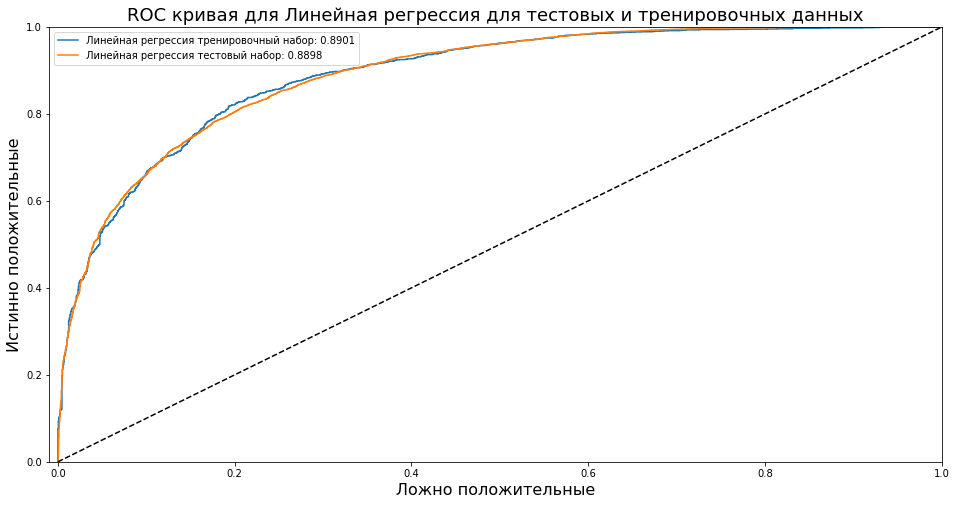

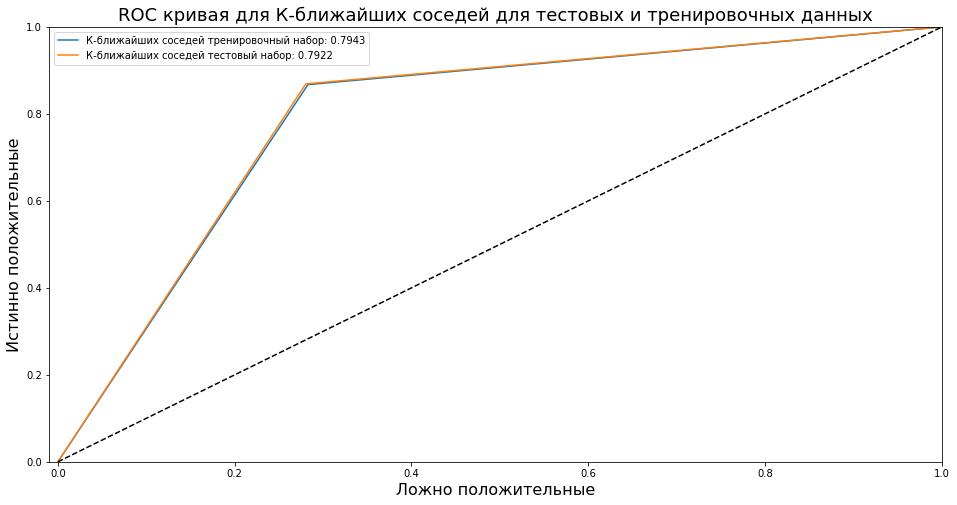

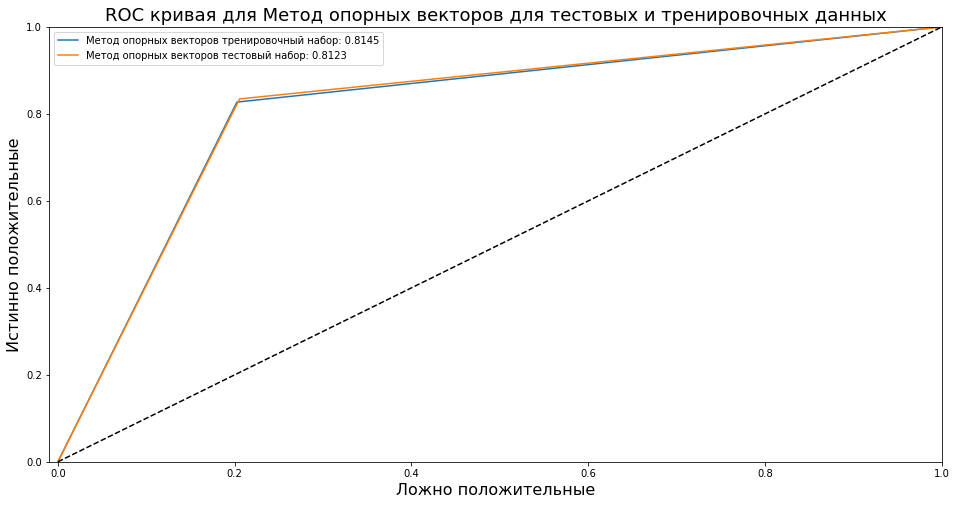

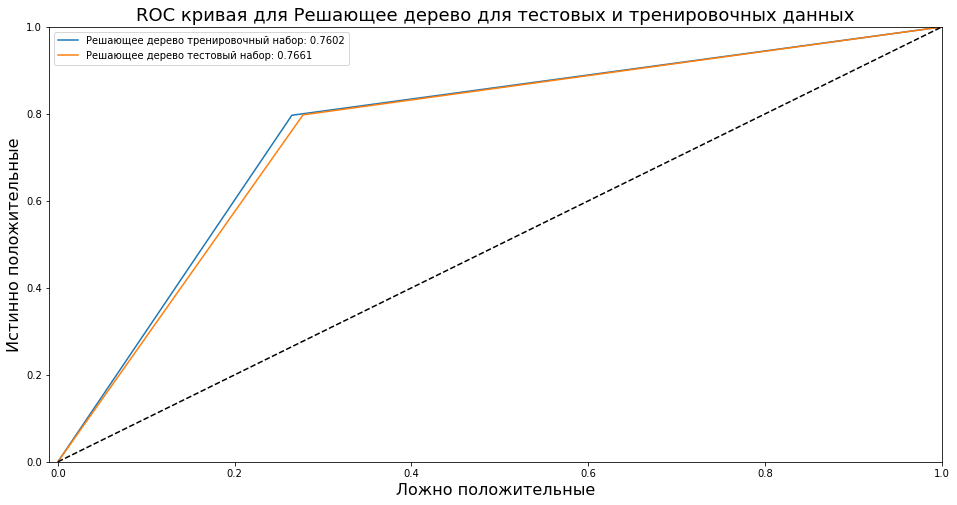

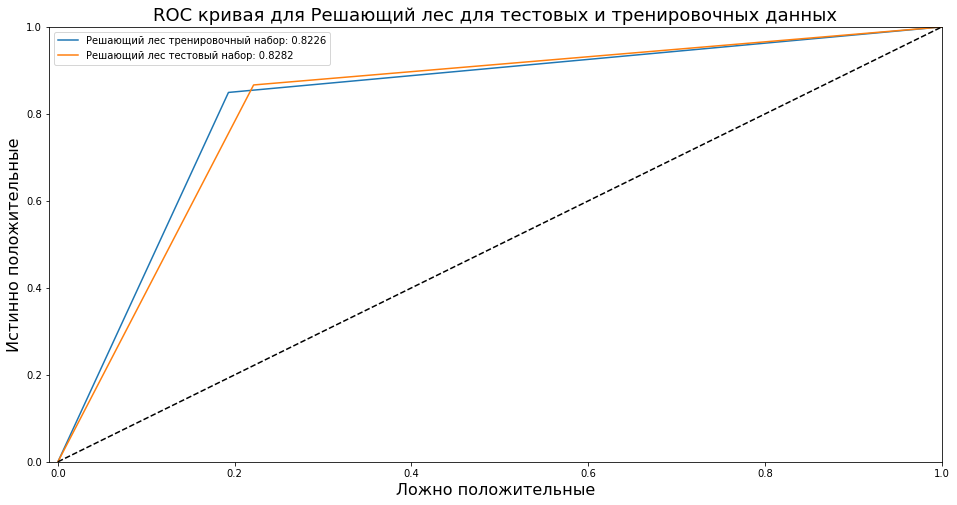

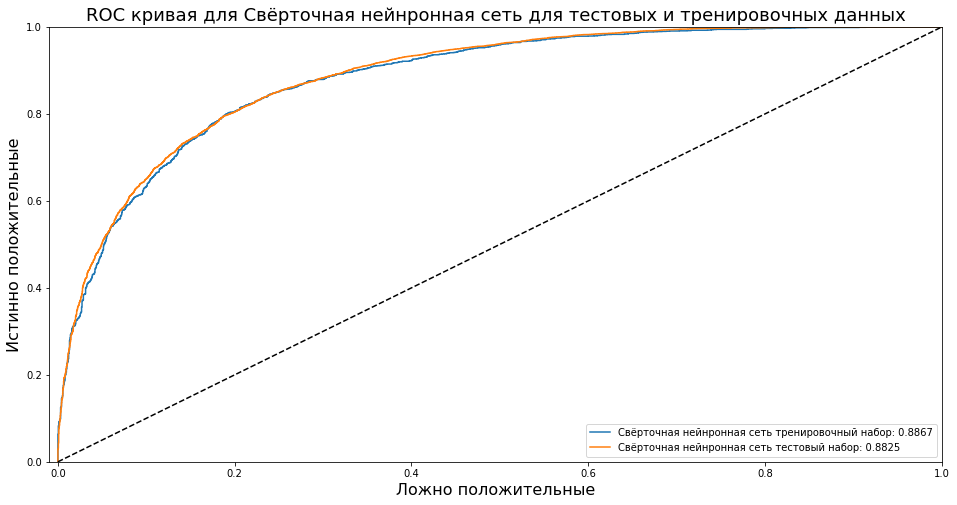

In [33]:
plot_auc(y_test, lin_reg_pred_test, y_train, lin_reg_pred_train, "Линейная регрессия")
plot_auc(y_test, knears_pred_test, y_train, knears_pred_train, "К-ближайших соседей")
plot_auc(y_test, svc_pred_test, y_train, svc_pred_train, "Метод опорных векторов")
plot_auc(y_test, tree_pred_test, y_train, tree_pred_train, "Решающее дерево")
plot_auc(y_test, forest_pred_test, y_train, forest_pred_train, "Решающий лес")
plot_auc(y_test, cnn_pred_test, y_train, cnn_pred_train, "Свёрточная нейнронная сеть")

**График для всех классификаторов сразу**

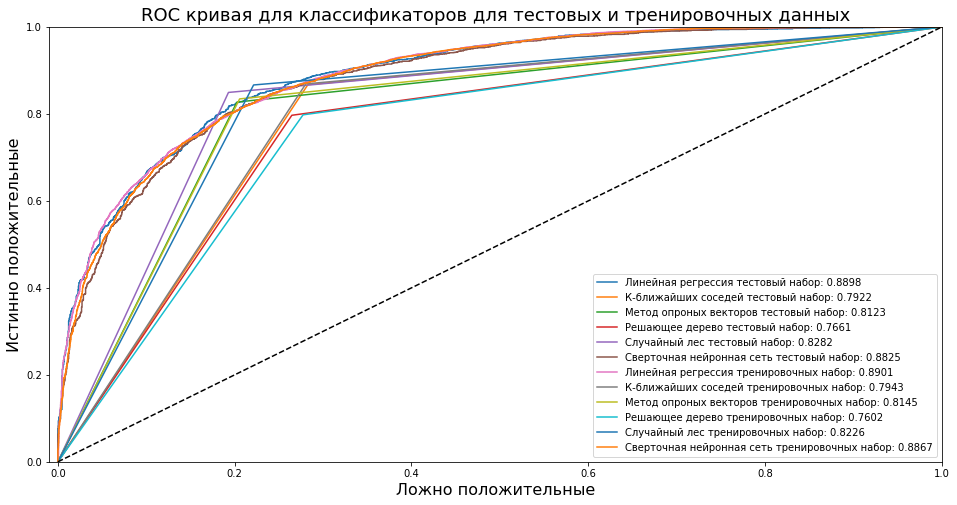

In [34]:
from sklearn.metrics import roc_curve

lin_fpr, lin_tpr, lin_thresold = roc_curve(y_test, lin_reg_pred_test)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knears_pred_test)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred_test)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred_test)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_test, forest_pred_test)
cnn_fpr, cnn_tpr, cnn_threshold = roc_curve(y_test, cnn_pred_test)

plt.figure(figsize=(16,8))
plt.title('ROC кривая для классификаторов для тестовых и тренировочных данных', fontsize=18)
plt.plot(lin_fpr, lin_tpr, label='Линейная регрессия тестовый набор: {:.4f}'.format(roc_auc_score(y_test, lin_reg_pred_test)))
plt.plot(knear_fpr, knear_tpr, label='К-ближайших соседей тестовый набор: {:.4f}'.format(roc_auc_score(y_test, knears_pred_test)))
plt.plot(svc_fpr, svc_tpr, label='Метод опроных векторов тестовый набор: {:.4f}'.format(roc_auc_score(y_test, svc_pred_test)))
plt.plot(tree_fpr, tree_tpr, label='Решающее дерево тестовый набор: {:.4f}'.format(roc_auc_score(y_test, tree_pred_test)))
plt.plot(forest_fpr, forest_tpr, label='Случайный лес тестовый набор: {:.4f}'.format(roc_auc_score(y_test, forest_pred_test)))
plt.plot(cnn_fpr, cnn_tpr, label='Cверточная нейронная сеть тестовый набор: {:.4f}'.format(roc_auc_score(y_test, cnn_pred_test)))

lin_fpr, lin_tpr, lin_thresold = roc_curve(y_train, lin_reg_pred_train)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred_train)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred_train)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred_train)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train, forest_pred_train)
cnn_fpr, cnn_tpr, cnn_threshold = roc_curve(y_train, cnn_pred_train)

plt.plot(lin_fpr, lin_tpr, label='Линейная регрессия тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, lin_reg_pred_train)))
plt.plot(knear_fpr, knear_tpr, label='К-ближайших соседей тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, knears_pred_train)))
plt.plot(svc_fpr, svc_tpr, label='Метод опроных векторов тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, svc_pred_train)))
plt.plot(tree_fpr, tree_tpr, label='Решающее дерево тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, tree_pred_train)))
plt.plot(forest_fpr, forest_tpr, label='Случайный лес тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, forest_pred_train)))
plt.plot(cnn_fpr, cnn_tpr, label='Cверточная нейронная сеть тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, cnn_pred_train)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('Ложно положительные', fontsize=16)
plt.ylabel('Истинно положительные', fontsize=16)
plt.legend()

Только тренировочные данные

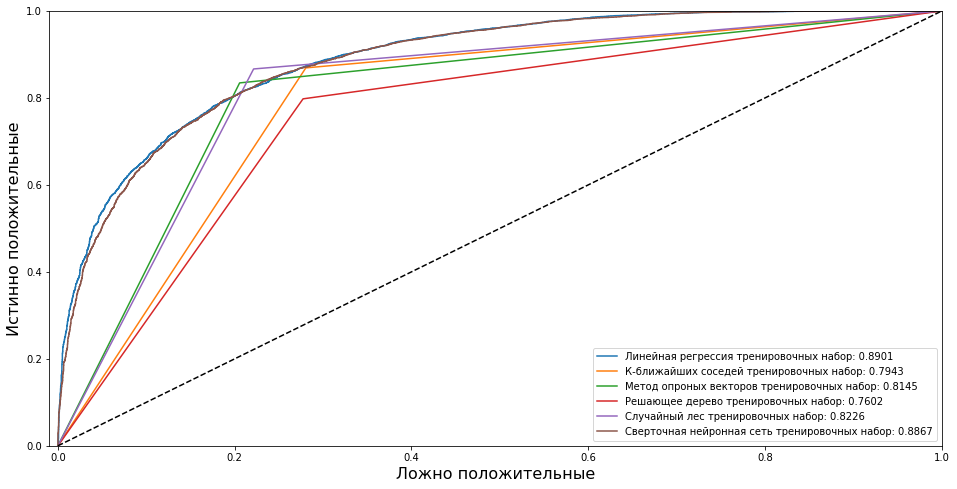

In [35]:
lin_fpr, lin_tpr, lin_thresold = roc_curve(y_train, lin_reg_pred_train)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred_train)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred_train)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred_train)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train, forest_pred_train)
cnn_fpr, cnn_tpr, cnn_threshold = roc_curve(y_train, cnn_pred_train)


roc_auc_train = [
    roc_auc_score(y_train, lin_reg_pred_train),
    roc_auc_score(y_train, knears_pred_train),
    roc_auc_score(y_train, svc_pred_train),
    roc_auc_score(y_train, tree_pred_train),
    roc_auc_score(y_train, forest_pred_train),
    roc_auc_score(y_train, cnn_pred_train)
]
roc_auc_test = [
    roc_auc_score(y_test, lin_reg_pred_test),
    roc_auc_score(y_test, knears_pred_test),
    roc_auc_score(y_test, svc_pred_test),
    roc_auc_score(y_test, tree_pred_test),
    roc_auc_score(y_test, forest_pred_test),
    roc_auc_score(y_test, cnn_pred_test)
]



plt.figure(figsize=(16,8))
plt.plot(lin_fpr, lin_tpr, label='Линейная регрессия тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, lin_reg_pred_train)))
plt.plot(knear_fpr, knear_tpr, label='К-ближайших соседей тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, knears_pred_train)))
plt.plot(svc_fpr, svc_tpr, label='Метод опроных векторов тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, svc_pred_train)))
plt.plot(tree_fpr, tree_tpr, label='Решающее дерево тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, tree_pred_train)))
plt.plot(forest_fpr, forest_tpr, label='Случайный лес тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, forest_pred_train)))
plt.plot(cnn_fpr, cnn_tpr, label='Cверточная нейронная сеть тренировочных набор: {:.4f}'.format(roc_auc_score(y_train, cnn_pred_train)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('Ложно положительные', fontsize=16)
plt.ylabel('Истинно положительные', fontsize=16)
plt.legend()

Только тестовые данные

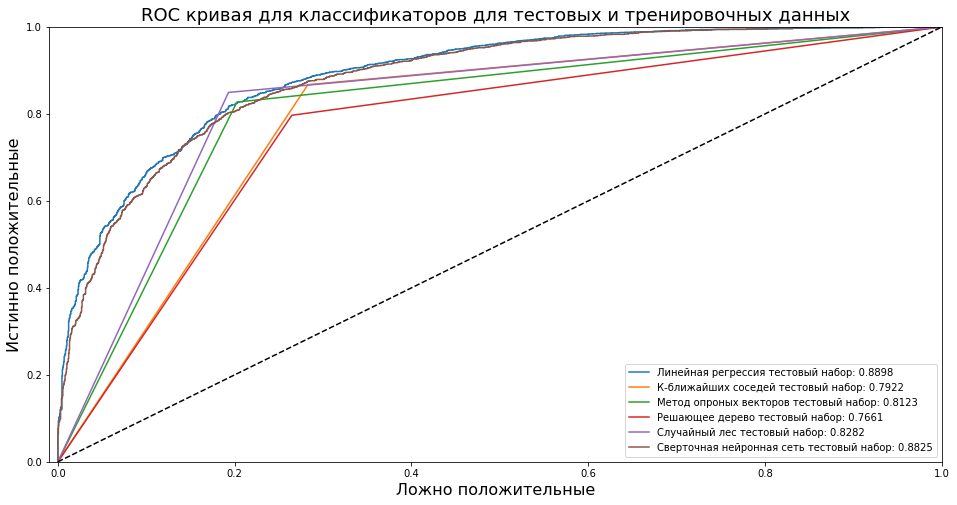

In [36]:
lin_fpr, lin_tpr, lin_thresold = roc_curve(y_test, lin_reg_pred_test)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knears_pred_test)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred_test)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred_test)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_test, forest_pred_test)
cnn_fpr, cnn_tpr, cnn_threshold = roc_curve(y_test, cnn_pred_test)

plt.figure(figsize=(16,8))
plt.title('ROC кривая для классификаторов для тестовых и тренировочных данных', fontsize=18)
plt.plot(lin_fpr, lin_tpr, label='Линейная регрессия тестовый набор: {:.4f}'.format(roc_auc_score(y_test, lin_reg_pred_test)))
plt.plot(knear_fpr, knear_tpr, label='К-ближайших соседей тестовый набор: {:.4f}'.format(roc_auc_score(y_test, knears_pred_test)))
plt.plot(svc_fpr, svc_tpr, label='Метод опроных векторов тестовый набор: {:.4f}'.format(roc_auc_score(y_test, svc_pred_test)))
plt.plot(tree_fpr, tree_tpr, label='Решающее дерево тестовый набор: {:.4f}'.format(roc_auc_score(y_test, tree_pred_test)))
plt.plot(forest_fpr, forest_tpr, label='Случайный лес тестовый набор: {:.4f}'.format(roc_auc_score(y_test, forest_pred_test)))
plt.plot(cnn_fpr, cnn_tpr, label='Cверточная нейронная сеть тестовый набор: {:.4f}'.format(roc_auc_score(y_test, cnn_pred_test)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('Ложно положительные', fontsize=16)
plt.ylabel('Истинно положительные', fontsize=16)
plt.legend()

Преобразуем данные для метрик

In [37]:
y_train_metrics = []
y_test_metrics = []
for y in y_train:
  y_train_metrics.append(int(y))
for y in y_test:
  y_test_metrics.append(int(y))

Метрика R2

In [38]:
from sklearn.metrics import r2_score
r2_train = [
    r2_score(y_train_metrics, lin_reg_pred_train),
    r2_score(y_train_metrics, knears_pred_train),
    r2_score(y_train_metrics, svc_pred_train),
    r2_score(y_train_metrics, tree_pred_train),
    r2_score(y_train_metrics, forest_pred_train),
    r2_score(y_train_metrics, cnn_pred_train)
]
r2_test = [
    r2_score(y_test_metrics, lin_reg_pred_test),
    r2_score(y_test_metrics, knears_pred_test),
    r2_score(y_test_metrics, svc_pred_test),
    r2_score(y_test_metrics, tree_pred_test),
    r2_score(y_test_metrics, forest_pred_test),
    r2_score(y_test_metrics, cnn_pred_test)
]


print("Значения R2")
print("Тренировочные данные")
print('Линейная регрессия: ', r2_train[0])
print('К-ближайших соседей: ', r2_train[1])
print('Метод опорных векторов: ', r2_train[2])
print('Решающее дерево классификатор: ', r2_train[3])
print('Случайный лес классификатор: ', r2_train[4])
print('Свёрточная нейронная сеть: ', r2_train[5])
print('----------------------------------------------------------------------')
print("Тестовые данные")
print('Линейная регрессия: ', r2_test[0])
print('К-ближайших соседей: ', r2_test[1])
print('Метод опорных векторов: ', r2_test[2])
print('Решающее дерево классификатор: ', r2_test[3])
print('Случайный лес классификатор: ', r2_test[4])
print('Свёрточная нейронная сеть: ', r2_test[5])

Значения R2
Тренировочные данные
Линейная регрессия:  0.40546084046523656
К-ближайших соседей:  0.20489218293903777
Метод опорных векторов:  0.2501228671431045
Решающее дерево классификатор:  0.039145530954398655
Случайный лес классификатор:  0.3001146760002309
Свёрточная нейронная сеть:  0.4397678363826747
----------------------------------------------------------------------
Тестовые данные
Линейная регрессия:  0.38679057761322666
К-ближайших соседей:  0.18835538483425818
Метод опорных векторов:  0.24892587850334336
Решающее дерево классификатор:  0.06814625124484286
Случайный лес классификатор:  0.31508749466495956
Свёрточная нейронная сеть:  0.4192441657370345


Метрика MAE

In [39]:
from sklearn.metrics import mean_absolute_error

mae_train = [
    mean_absolute_error(y_train_metrics, lin_reg_pred_train),
    mean_absolute_error(y_train_metrics, knears_pred_train),
    mean_absolute_error(y_train_metrics, svc_pred_train),
    mean_absolute_error(y_train_metrics, tree_pred_train),
    mean_absolute_error(y_train_metrics, forest_pred_train),
    mean_absolute_error(y_train_metrics, cnn_pred_train)
]
mae_test = [
    mean_absolute_error(y_test_metrics, lin_reg_pred_test),
    mean_absolute_error(y_test_metrics, knears_pred_test),
    mean_absolute_error(y_test_metrics, svc_pred_test),
    mean_absolute_error(y_test_metrics, tree_pred_test),
    mean_absolute_error(y_test_metrics, forest_pred_test),
    mean_absolute_error(y_test_metrics, cnn_pred_test)
]


print("Значения MAE")
print("Тренировочные данные")
print("Тренировочные данные")
print('Линейная регрессия: ', mae_train[0])
print('К-ближайших соседей: ', mae_train[1])
print('Метод опорных векторов: ', mae_train[2])
print('Решающее дерево классификатор: ', mae_train[3])
print('Случайный лес классификатор: ', mae_train[4])
print('Свёрточная нейронная сеть: ', mae_train[5])
print('----------------------------------------------------------------------')
print("Тестовые данные")
print('Линейная регрессия: ', mae_test[0])
print('К-ближайших соседей: ', mae_test[1])
print('Метод опорных векторов: ', mae_test[2])
print('Решающее дерево классификатор: ', mae_test[3])
print('Случайный лес классификатор: ', mae_test[4])
print('Свёрточная нейронная сеть: ', mae_test[5])

Значения MAE
Тренировочные данные
Тренировочные данные
Линейная регрессия:  0.32042454843675927
К-ближайших соседей:  0.19317524580682474
Метод опорных векторов:  0.18218623481781376
Решающее дерево классификатор:  0.2334441873915558
Случайный лес классификатор:  0.1700404858299595
Свёрточная нейронная сеть:  0.29370922209701955
----------------------------------------------------------------------
Тестовые данные
Линейная регрессия:  0.33600584437733366
К-ближайших соседей:  0.20148045338885034
Метод опорных векторов:  0.18644459865833912
Решающее дерево классификатор:  0.2313208420078649
Случайный лес классификатор:  0.17002081887578072
Свёрточная нейронная сеть:  0.30663816824327617


Метрика MSE

In [40]:
from sklearn.metrics import mean_squared_error


mse_train = [
    mean_squared_error(y_train_metrics, lin_reg_pred_train, squared=True),
    mean_squared_error(y_train_metrics, knears_pred_train, squared=True),
    mean_squared_error(y_train_metrics, svc_pred_train, squared=True),
    mean_squared_error(y_train_metrics, tree_pred_train, squared=True),
    mean_squared_error(y_train_metrics, forest_pred_train, squared=True),
    mean_squared_error(y_train_metrics, cnn_pred_train, squared=True)
]
mse_test = [
    mean_squared_error(y_test_metrics, lin_reg_pred_test, squared=True),
    mean_squared_error(y_test_metrics, knears_pred_test, squared=True),
    mean_squared_error(y_test_metrics, svc_pred_test, squared=True),
    mean_squared_error(y_test_metrics, tree_pred_test, squared=True),
    mean_squared_error(y_test_metrics, forest_pred_test, squared=True),
    mean_squared_error(y_test_metrics, cnn_pred_test, squared=True)
]

print("Значения MSE")
print("Тренировочные данные")
print("Тренировочные данные")
print('Линейная регрессия: ', mse_train[0])
print('К-ближайших соседей: ', mse_train[1])
print('Метод опорных векторов: ', mse_train[2])
print('Решающее дерево классификатор: ', mse_train[3])
print('Случайный лес классификатор: ', mse_train[4])
print('Свёрточная нейронная сеть: ', mse_train[5])
print('----------------------------------------------------------------------')
print("Тестовые данные")
print('Линейная регрессия: ', mse_test[0])
print('К-ближайших соседей: ', mse_test[1])
print('Метод опорных векторов: ', mse_test[2])
print('Решающее дерево классификатор: ', mse_test[3])
print('Случайный лес классификатор: ', mse_test[4])
print('Свёрточная нейронная сеть: ', mse_test[5])

Значения MSE
Тренировочные данные
Тренировочные данные
Линейная регрессия:  0.14444613148119154
К-ближайших соседей:  0.19317524580682474
Метод опорных векторов:  0.18218623481781376
Решающее дерево классификатор:  0.2334441873915558
Случайный лес классификатор:  0.1700404858299595
Свёрточная нейронная сеть:  0.13611108279088702
----------------------------------------------------------------------
Тестовые данные
Линейная регрессия:  0.15222144043864896
К-ближайших соседей:  0.20148045338885034
Метод опорных векторов:  0.18644459865833912
Решающее дерево классификатор:  0.2313208420078649
Случайный лес классификатор:  0.17002081887578072
Свёрточная нейронная сеть:  0.14416524992484314


Метрика RMSE

In [41]:
from sklearn.metrics import mean_squared_error

rmse_train = [
    mean_squared_error(y_train_metrics, lin_reg_pred_train, squared=False),
    mean_squared_error(y_train_metrics, knears_pred_train, squared=False),
    mean_squared_error(y_train_metrics, svc_pred_train, squared=False),
    mean_squared_error(y_train_metrics, tree_pred_train, squared=False),
    mean_squared_error(y_train_metrics, forest_pred_train, squared=False),
    mean_squared_error(y_train_metrics, cnn_pred_train, squared=False)
]
rmse_test = [
    mean_squared_error(y_test_metrics, lin_reg_pred_test, squared=False),
    mean_squared_error(y_test_metrics, knears_pred_test, squared=False),
    mean_squared_error(y_test_metrics, svc_pred_test, squared=False),
    mean_squared_error(y_test_metrics, tree_pred_test, squared=False),
    mean_squared_error(y_test_metrics, forest_pred_test, squared=False),
    mean_squared_error(y_test_metrics, cnn_pred_test, squared=False)
]


print("Значения RMSE")
print("Тренировочные данные")
print("Тренировочные данные")
print('Линейная регрессия: ', rmse_train[0])
print('К-ближайших соседей: ', rmse_train[1])
print('Метод опорных векторов: ', rmse_train[2])
print('Решающее дерево классификатор: ', rmse_train[3])
print('Случайный лес классификатор: ', rmse_train[4])
print('Свёрточная нейронная сеть: ', rmse_train[5])
print('----------------------------------------------------------------------')
print("Тестовые данные")
print('Линейная регрессия: ', rmse_test[0])
print('К-ближайших соседей: ', rmse_test[1])
print('Метод опорных векторов: ', rmse_test[2])
print('Решающее дерево классификатор: ', rmse_test[3])
print('Случайный лес классификатор: ', rmse_test[4])
print('Свёрточная нейронная сеть: ', rmse_test[5])

Значения RMSE
Тренировочные данные
Тренировочные данные
Линейная регрессия:  0.3800606944702274
К-ближайших соседей:  0.4395170597449259
Метод опорных векторов:  0.42683279491835413
Решающее дерево классификатор:  0.4831606227659243
Случайный лес классификатор:  0.41235965591939217
Свёрточная нейронная сеть:  0.3689323553049895
----------------------------------------------------------------------
Тестовые данные
Линейная регрессия:  0.39015566180519407
К-ближайших соседей:  0.448865740939148
Метод опорных векторов:  0.43179230963316045
Решающее дерево классификатор:  0.4809582539138557
Случайный лес классификатор:  0.41233580838411393
Свёрточная нейронная сеть:  0.37969099268331763


In [42]:
d = {'model':
     ['Линейная регрессия', 
      'К-ближайших соседей',
      'Метод опорных векторов', 
      'Решающее дерево классификатор',
      'Случайный лес классификатор',
      'Свёрточная нейронная сеть'],
    'roc_auc_score_train':
     [roc_auc_train[0], 
      roc_auc_train[1],
      roc_auc_train[2], 
      roc_auc_train[3],
      roc_auc_train[4],
      roc_auc_train[5]],
    'roc_auc_score_test':
     [roc_auc_test[0], 
      roc_auc_test[1],
      roc_auc_test[2], 
      roc_auc_test[3],
      roc_auc_test[4],
      roc_auc_test[5]],
    'r2_train':
     [r2_train[0], 
      r2_train[1],
      r2_train[2], 
      r2_train[3],
      r2_train[4],
      r2_train[5]],
    'r2_test':
     [r2_test[0], 
      r2_test[1],
      r2_test[2], 
      r2_test[3],
      r2_test[4],
      r2_test[5]],
    'MAE_train':
     [mae_train[0], 
      mae_train[1],
      mae_train[2], 
      mae_train[3],
      mae_train[4],
      mae_train[5]],
    'MAE_test':
     [mae_test[0], 
      mae_test[1],
      mae_test[2], 
      mae_test[3],
      mae_test[4],
      mae_test[5]],
    'MSE_train':
     [mse_train[0], 
      mse_train[1],
      mse_train[2], 
      mse_train[3],
      mse_train[4],
      mse_train[5]],
    'MSE_test':
     [mse_test[0], 
      mse_test[1],
      mse_test[2], 
      mse_test[3],
      mse_test[4],
      mse_test[5]],
    'RMSE_train':
     [rmse_train[0], 
      rmse_train[1],
      rmse_train[2], 
      rmse_train[3],
      rmse_train[4],
      rmse_train[5]],
    'RMSE_test':
     [rmse_test[0], 
      rmse_test[1],
      rmse_test[2], 
      rmse_test[3],
      rmse_test[4],
      rmse_test[5]]
    }

metric_data = pd.DataFrame(data=d)

metric_data

,model,roc_auc_score_train,roc_auc_score_test,r2_train,r2_test,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Линейная регрессия,0.890120,0.889838,0.405461,0.386791,0.320425,0.336006,0.144446,0.152221,0.380061,0.390156
1,К-ближайших соседей,0.794279,0.792218,0.204892,0.188355,0.193175,0.201480,0.193175,0.201480,0.439517,0.448866
2,Метод опорных векторов,0.814454,0.812310,0.250123,0.248926,0.182186,0.186445,0.182186,0.186445,0.426833,0.431792
3,Решающее дерево классификатор,0.760248,0.766098,0.039146,0.068146,0.233444,0.231321,0.233444,0.231321,0.483161,0.480958
4,Случайный лес классификатор,0.822581,0.828205,0.300115,0.315087,0.170040,0.170021,0.170040,0.170021,0.412360,0.412336
5,Свёрточная нейронная сеть,0.886694,0.882468,0.439768,0.419244,0.293709,0.306638,0.136111,0.144165,0.368932,0.379691
